In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [3]:
MAXIMUM_Q_VALUE = 0.01
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [10]:
pda_results_df = pd.read_csv('/Users/darylwilding-mcbride/percolator-output/190719_Hela_Ecoli_1to1-pda.percolator.target.peptides.txt', sep='\t', index_col=False)
pda_results_df = pda_results_df[pda_results_df['percolator q-value'] <= MAXIMUM_Q_VALUE]


In [11]:
mq_results_df = pd.read_csv('/Users/darylwilding-mcbride/percolator-output/190719_Hela_Ecoli_1to1-mq.percolator.target.peptides.txt', sep='\t', index_col=False)
mq_results_df = mq_results_df[mq_results_df['percolator q-value'] <= MAXIMUM_Q_VALUE]

In [12]:
len(pda_results_df), len(mq_results_df)

(17334, 16375)

In [15]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

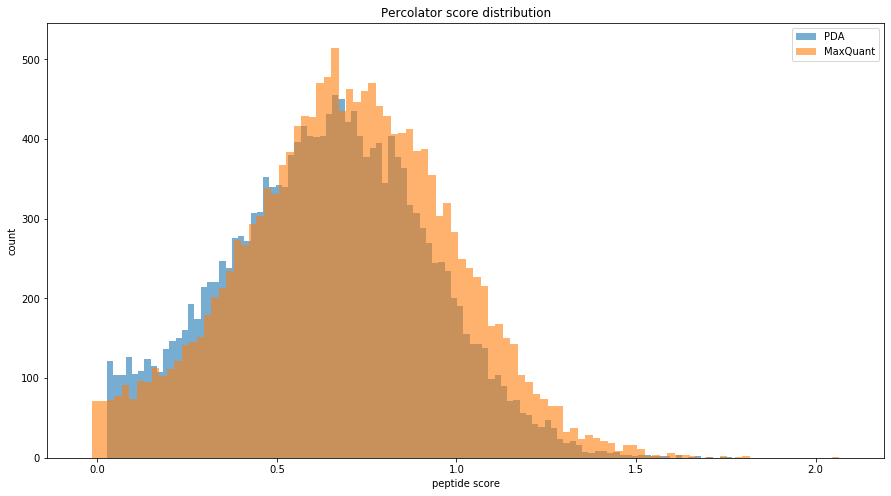

In [46]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Percolator score distribution')

h_bins = 100
hist, bins, _ = plt.hist(pda_results_df['percolator score'], bins=h_bins, label='PDA', color=tableau20_mpl[0], alpha=0.6)
hist, bins, _ = plt.hist(mq_results_df['percolator score'], bins=h_bins, label='MaxQuant', color=tableau20_mpl[2], alpha=0.6)
plt.legend(loc='best')
plt.xlabel('peptide score')
plt.ylabel('count')

# plt.xlim([25,150])
# plt.ylim([0,45])

plt.show()

In [38]:
# for each unique peptide sequence / charge / modification, what was PDA's best score and what was MQ's best score?


In [27]:
# number of peptide matches
pda_peptides = list(pda_results_df.sequence.unique())
mq_peptides = list(mq_results_df.sequence.unique())

In [28]:
len(mq_peptides)

16375

In [29]:
mq_set = set(mq_peptides)
pda_set = set(pda_peptides)

In [30]:
combined_set = mq_set.union(pda_set)

In [31]:
len(combined_set)

19878

In [33]:
best_identifications_l = []
for peptide in combined_set:
    pda_ids = pda_results_df[pda_results_df.sequence == peptide][['charge','percolator score']]
    mq_ids = mq_results_df[mq_results_df.sequence == peptide][['charge','percolator score']]
    same_peptide_different_charge = False
    if (len(pda_ids) > 0) and (len(mq_ids) > 0):
        charge_match = pd.merge(pda_ids, mq_ids, how='inner', left_on=['charge'], right_on = ['charge'])
        if len(charge_match) > 0:
            best_pda_score = charge_match['percolator score_x'].max()
            best_mq_score = charge_match['percolator score_y'].max()
        else:  # didn't match on charge but record score anyway for debugging
            best_pda_score = pda_ids['percolator score'].max()
            best_mq_score = mq_ids['percolator score'].max()
            same_peptide_different_charge = True
    elif (len(pda_ids) > 0) and (len(mq_ids) == 0):
        best_pda_score = pda_ids['percolator score'].max()
        best_mq_score = None
    elif (len(pda_ids) == 0) and (len(mq_ids) > 0):
        best_pda_score = None
        best_mq_score = mq_ids['percolator score'].max()
    else:
        print("this shouldn't happen")
    best_identifications_l.append((peptide,best_pda_score,best_mq_score,same_peptide_different_charge))

best_identifications_df = pd.DataFrame(best_identifications_l, columns=['peptide','pda_score','mq_score','different_charge'])

In [34]:
best_identifications_df.head()

,peptide,pda_score,mq_score,different_charge
0,GAEAANVTGPDGVPVEGSR,1.071552,1.079722,False
1,TMQALEIELQSQLSMK,1.085603,0.976279,False
2,ASLPTIELALK,NaN,0.094119,False
3,AWHSSSETIAK,0.612099,0.845528,False
4,TYLTITDTQLVNSLLEK,0.946639,0.913255,False


In [35]:
match_both_df = best_identifications_df[pd.notna(best_identifications_df.pda_score) & pd.notna(best_identifications_df.mq_score)]
match_pda_only_df = best_identifications_df[pd.notna(best_identifications_df.pda_score) & pd.isna(best_identifications_df.mq_score)]
match_mq_only_df = best_identifications_df[pd.isna(best_identifications_df.pda_score) & pd.notna(best_identifications_df.mq_score)]

In [38]:
match_both_same_charge_df = match_both_df[match_both_df.different_charge == False]
match_both_different_charge_df = match_both_df[match_both_df.different_charge == True]

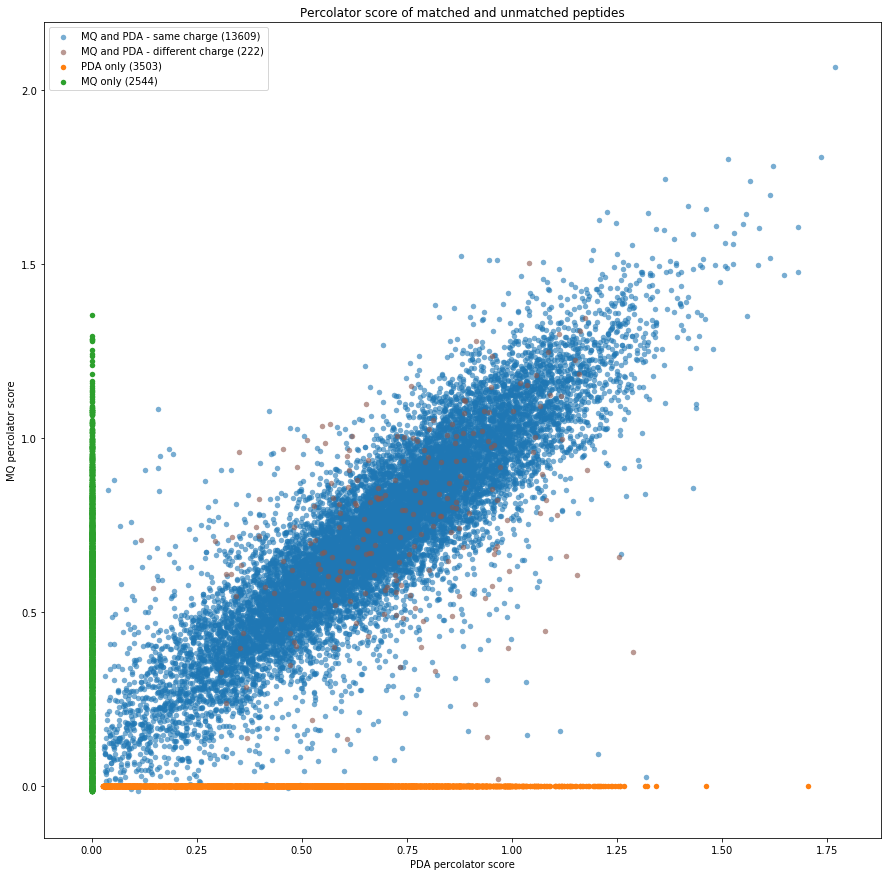

In [47]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Percolator score of matched and unmatched peptides')

ax.scatter(match_both_same_charge_df.pda_score, match_both_same_charge_df.mq_score, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=0.6, label="MQ and PDA - same charge ({})".format(len(match_both_same_charge_df)))
ax.scatter(match_both_different_charge_df.pda_score, match_both_different_charge_df.mq_score, marker='o', color=tableau20_mpl[10], lw=0, s=30, alpha=0.6, label="MQ and PDA - different charge ({})".format(len(match_both_different_charge_df)))
ax.scatter(match_pda_only_df.pda_score, np.full((len(match_pda_only_df)), 0), marker='o', color=tableau20_mpl[2], lw=0, s=30, alpha=1.0, label="PDA only ({})".format(len(match_pda_only_df)))
ax.scatter(np.full((len(match_mq_only_df)), 0), match_mq_only_df.mq_score, marker='o', color=tableau20_mpl[4], lw=0, s=30, alpha=1.0, label="MQ only ({})".format(len(match_mq_only_df)))

plt.legend(loc='best')
plt.xlabel('PDA percolator score')
plt.ylabel('MQ percolator score')

# plt.xlim([-5,150])
# plt.ylim([-5,150])

plt.show()